,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,407.0,3.303249,0.0,NaN,NaN,NaN
1,416.0,3.330059,-9.0,-0.02681,0.372126,NaN


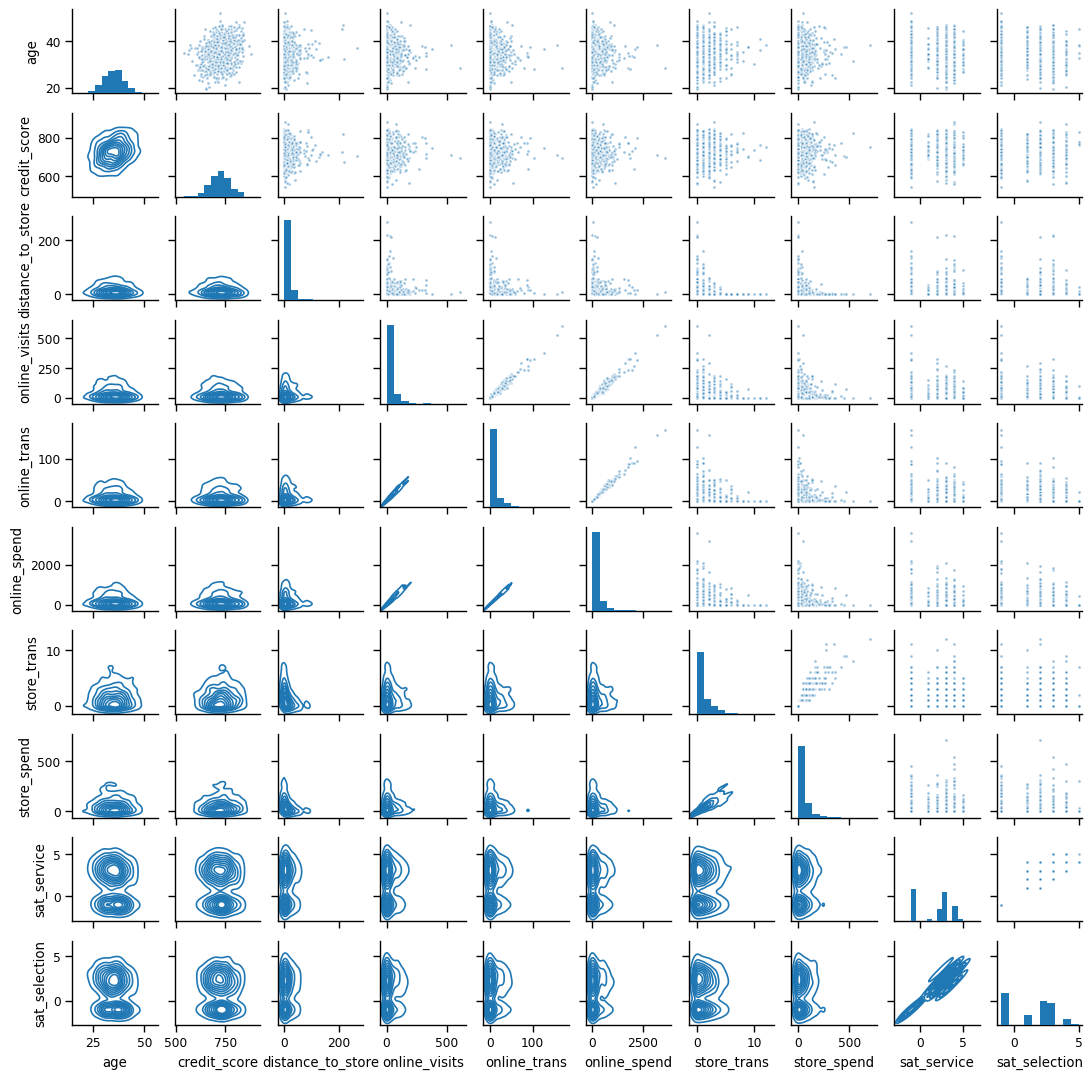

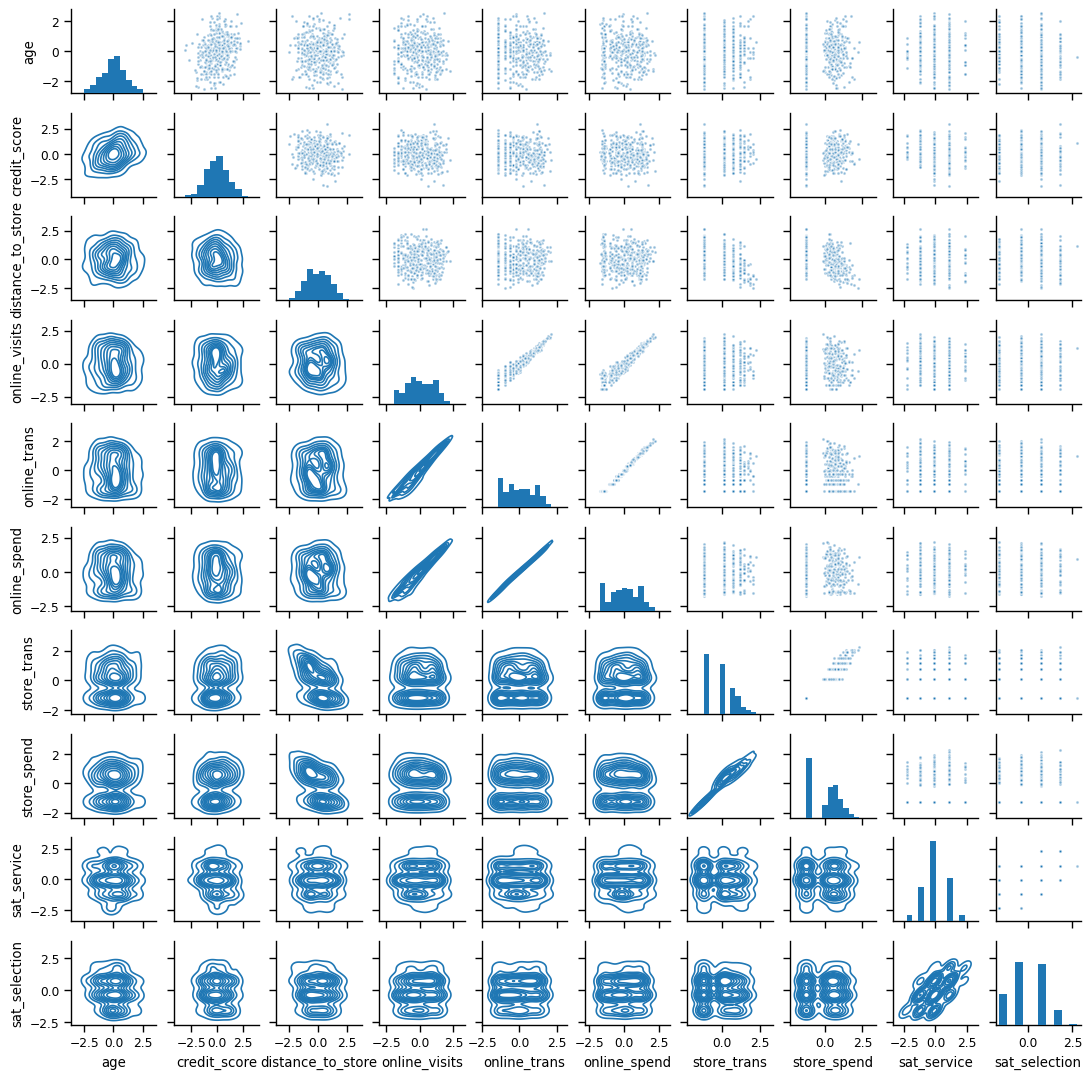

In [68]:
# ------------------------------
# Linear Modeling: Online Spend Predictors
# ------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats import anova as sms_anova
import scipy.stats as ss
import sklearn.preprocessing as pp

# ------------------------------
# Load Dataset
# ------------------------------

# Customer-level purchase and behavior dataset
cust_df = pd.read_csv('http://bit.ly/PMR-ch8pt1')

# Preview data structure
cust_df.head(5)
cust_df.describe(include='all').T

# ------------------------------
# Initial Linear Model: Online Spend (Raw Data)
# ------------------------------

# Predict online_spend using all relevant behavioral/demographic predictors
spend_m1 = smf.ols(
    ('online_spend ~ age + credit_score + email + distance_to_store '
     '+ online_visits + online_trans + store_trans + store_spend '
     '+ sat_service + sat_selection'),
    data=cust_df.loc[cust_df.online_spend > 0, 'age':]
).fit()

# View regression summary (coeffs, std err, R², p-values, etc.)
spend_m1.summary()

# ------------------------------
# Check for Correlation & Skewness: PairGrid Plot (Raw Data)
# ------------------------------

# Use seaborn PairGrid to visually explore relationships and collinearity
sns.set_context('paper')
g = sns.PairGrid(cust_df.loc[:, 'age':].fillna(-1), height=1.1)
g.map_upper(plt.scatter, linewidth=1, edgecolor='w', s=5, alpha=0.5)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)

# ------------------------------
# Normalize and Scale Using Box-Cox + Standardization
# ------------------------------

# Function to apply Box-Cox transformation and z-score scaling
def autotransform(x):
    x_bc, _ = ss.boxcox(1 + x)
    return pp.scale(x_bc)

# Subset data with no missing values and positive online_spend
idx_complete = (cust_df.isna().sum(axis=1) == 0)
cust_df_bc = cust_df.loc[idx_complete & (cust_df.online_spend > 0), 'age':].copy()

# Apply transformation to all numeric columns (except 'email')
cols_to_transform = cust_df_bc.columns.difference(['email'])
cust_df_bc[cols_to_transform] = cust_df_bc[cols_to_transform].apply(autotransform)

# ------------------------------
# PairGrid Plot (Transformed Data)
# ------------------------------

# Replot with normalized and scaled data
g = sns.PairGrid(cust_df_bc, height=1.1)
g.map_upper(plt.scatter, linewidth=1, edgecolor='w', s=5, alpha=0.5)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)

# ------------------------------
# Linear Model: Transformed Predictors
# ------------------------------

# Refit model with standardized predictors
spend_m2 = smf.ols(
    ('online_spend ~ age + credit_score + email + distance_to_store '
     '+ online_visits + online_trans + store_trans + store_spend '
     '+ sat_service + sat_selection'),
    data=cust_df_bc
).fit()

spend_m2.summary()

# ------------------------------
# Simpler Model: Online Spend ~ Online Transactions Only
# ------------------------------

# Evaluate simplified model using only online_trans
spend_m3 = smf.ols(
    'online_spend ~ online_trans',
    data=cust_df_bc
).fit()

spend_m3.summary()

# ------------------------------
# Model Comparison via ANOVA
# ------------------------------

# Compare full model vs simpler model using ANOVA F-test
sms_anova.anova_lm(spend_m2, spend_m3)


In [69]:
# ------------------------------
# Remediating Collinearity in Linear Regression
# ------------------------------

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import decomposition

# ------------------------------
# Check VIF (Variance Inflation Factor): One Variable Example
# ------------------------------

# VIF quantifies how much a variable is inflated due to correlation with other predictors
# Here, we check VIF for the second column (index 1) of the model matrix (exog)
print("VIF for second predictor in spend_m2:", variance_inflation_factor(spend_m2.model.exog, 1))

# ------------------------------
# Function: Print VIF for All Predictors in Model
# ------------------------------

def print_variance_inflation_factors(model):
    for i, param in enumerate(model.params.index):
        vif = variance_inflation_factor(model.model.exog, i)
        print('VIF: {:.3f}, Parameter: {}'.format(vif, param))

print_variance_inflation_factors(spend_m2)
print('-------------------------------------')

# ------------------------------
# Omit Highly Correlated Predictors (Manually)
# ------------------------------

# Based on high VIFs, we manually remove 'online_trans' and 'store_trans' from the model
spend_m4 = smf.ols(
    'online_spend ~ age + credit_score + email + distance_to_store '
    '+ online_visits + store_spend + sat_service + sat_selection',
    data=cust_df_bc
).fit()

spend_m4.summary()

# Re-check VIFs after dropping correlated features
print_variance_inflation_factors(spend_m4)
print('-------------------------------------')

# ------------------------------
# Use PCA to Combine Correlated Predictors
# ------------------------------

# PCA reduces multicollinearity by creating new uncorrelated features (principal components)

# Combine 'online_visits' and 'online_trans' into a single 'online' feature
online_pca = decomposition.PCA().fit_transform(
    cust_df_bc[['online_visits', 'online_trans']]
)
cust_df_bc['online'] = online_pca[:, 0]  # First principal component (most variance)

# Combine 'store_spend' and 'store_trans' into a single 'store' feature
store_pca = decomposition.PCA().fit_transform(
    cust_df_bc[['store_spend', 'store_trans']]
)
cust_df_bc['store'] = store_pca[:, 0]

# ------------------------------
# Final Model Using PCA Components
# ------------------------------

spend_m5 = smf.ols(
    'online_spend ~ age + credit_score + email + distance_to_store '
    '+ online + store + sat_service + sat_selection',
    data=cust_df_bc
).fit()

spend_m5.summary()

# VIFs should now be lower due to reduced collinearity
print_variance_inflation_factors(spend_m5)
print('-------------------------------------')

VIF for second predictor in spend_m2: 1.0505934511549064
VIF: 6.504, Parameter: Intercept
VIF: 1.051, Parameter: email[T.yes]
VIF: 1.095, Parameter: age
VIF: 1.112, Parameter: credit_score
VIF: 1.375, Parameter: distance_to_store
VIF: 13.354, Parameter: online_visits
VIF: 13.413, Parameter: online_trans
VIF: 15.977, Parameter: store_trans
VIF: 15.254, Parameter: store_spend
VIF: 1.524, Parameter: sat_service
VIF: 1.519, Parameter: sat_selection
-------------------------------------
VIF: 6.450, Parameter: Intercept
VIF: 1.040, Parameter: email[T.yes]
VIF: 1.082, Parameter: age
VIF: 1.104, Parameter: credit_score
VIF: 1.299, Parameter: distance_to_store
VIF: 1.028, Parameter: online_visits
VIF: 1.313, Parameter: store_spend
VIF: 1.518, Parameter: sat_service
VIF: 1.518, Parameter: sat_selection
-------------------------------------
VIF: 6.474, Parameter: Intercept
VIF: 1.045, Parameter: email[T.yes]
VIF: 1.082, Parameter: age
VIF: 1.102, Parameter: credit_score
VIF: 1.337, Parameter: dis

In [4]:
#Basics of Logistic Regression Model
from scipy.special import expit
from scipy.special import logit

#Computing by hand with expit
np.exp(0) / (np.exp(0) + 1)
expit(0)
expit(-np.inf) #likelihood 0
expit(2) #moderate prob = 88% chance
expit(-0.2) #weak likelihood


#Looking at the logit model
np.log(0.88 / (1 - 0.88)) #moderate Likelihood
logit(0.88) #equivalent to hand computation

1.9924301646902063

In [5]:
#Data for logistice Regression of Season Passes

pass_df = pd.read_csv('http://bit.ly/PMR-ch8pt2')
pass_df.Pass = pass_df.Pass.astype(
    pd.api.types.CategoricalDtype(categories = ['YesPass','NoPass'],
                                  ordered = True))
pass_df.Promo = pass_df.Promo.astype(
    pd.api.types.CategoricalDtype(categories = ['NoBundle', 'Bundle'],
                                  ordered = True))

pass_df.head()

pass_df.describe().T



,count,unique,top,freq
Channel,3156,3,Mail,1328
Promo,3156,2,Bundle,1674
Pass,3156,2,YesPass,1589


In [57]:
# ------------------------------
# Logistic Regression with statsmodels
# ------------------------------

import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from scipy.special import expit  # sigmoid function

# ------------------------------
# Fit Logistic Model
# ------------------------------

# Model: Predicting 'Pass' using 'Promo' as a binary predictor
pass_m1 = smf.glm(
    'Pass ~ Promo',
    data=pass_df,
    family=sm.families.Binomial()
).fit()

# View model summary (coefficients, standard errors, z-stats, p-values)
pass_m1.summary()


# ------------------------------
# Coefficients and Odds Ratios
# ------------------------------

# Extract model coefficients
pass_intercept = pass_m1.params.iloc[0]   # Intercept (no promo)
pass_promo_t   = pass_m1.params.iloc[1]   # Coefficient for Promo

# Convert log-odds to odds ratio (easier interpretation)
odds_ratio_promo = np.exp(pass_promo_t)  # Effect of promo on odds
print('Odds Ratio (Promo vs No Promo): {:.3f}'.format(odds_ratio_promo))

# ------------------------------
# Estimated Odds
# ------------------------------

# Odds when Promo = 1 (with bundle)
odds_with_bundle = np.exp(pass_intercept + pass_promo_t)
print('Odds of pass:no pass, with bundle: {:.3f} : 1'.format(odds_with_bundle))

# Odds when Promo = 0 (no bundle)
odds_no_bundle = np.exp(pass_intercept)
print('Odds of pass:no pass, without bundle: {:.3f} : 1'.format(odds_no_bundle))

# ------------------------------
# Estimated Probabilities
# ------------------------------

# Probability of passing with bundle
prob_pass_with_bundle = odds_with_bundle / (1 + odds_with_bundle)
print('Probability of pass, with bundle: {:.3f}'.format(prob_pass_with_bundle))

# Probability of passing without bundle
prob_pass_no_bundle = odds_no_bundle / (1 + odds_no_bundle)
print('Probability of pass, without bundle: {:.3f}'.format(prob_pass_no_bundle))

# ------------------------------
# Odds Ratio Calculated from Probabilities
# ------------------------------

# Manually calculate odds ratio from probability formula
odds_ratio_manual = (
    (prob_pass_with_bundle / (1 - prob_pass_with_bundle)) /
    (prob_pass_no_bundle / (1 - prob_pass_no_bundle))
)
print('Manual Odds Ratio: {:.3f}'.format(odds_ratio_manual))

# Confirm it matches exponentiated coefficient
print('Odds Ratio (via np.exp): {:.3f}'.format(np.exp(pass_promo_t)))


# ------------------------------
# Model-Wide Odds Ratios and Confidence Intervals
# ------------------------------

# Odds ratios for all model parameters
print(np.exp(pass_m1.params))

# 95% confidence intervals for odds ratios
print(np.exp(pass_m1.conf_int()))


# ------------------------------
# (Optional) Quick sanity check:
# What does expit(log-odds) / (1 - expit(log-odds)) equal?
# Should return odds, since odds = p / (1 - p)
print("Quick odds check from expit:", expit(0.3888) / (1 - expit(0.3888)))



Odds Ratio (Promo vs No Promo): 1.475
Odds of pass:no pass, with bundle: 1.217 : 1
Odds of pass:no pass, without bundle: 0.825 : 1
Probability of pass, with bundle: 0.549
Probability of pass, without bundle: 0.452
Manual Odds Ratio: 1.475
Odds Ratio (via np.exp): 1.475
Intercept          0.825123
Promo[T.Bundle]    1.475196
dtype: float64
                        0         1
Intercept        0.744890  0.913998
Promo[T.Bundle]  1.281868  1.697681
Quick odds check from expit: 1.4752094799309121


Channel  Email  Mail  Park
Pass                      
YesPass     65   601   923
NoPass     568   727   272


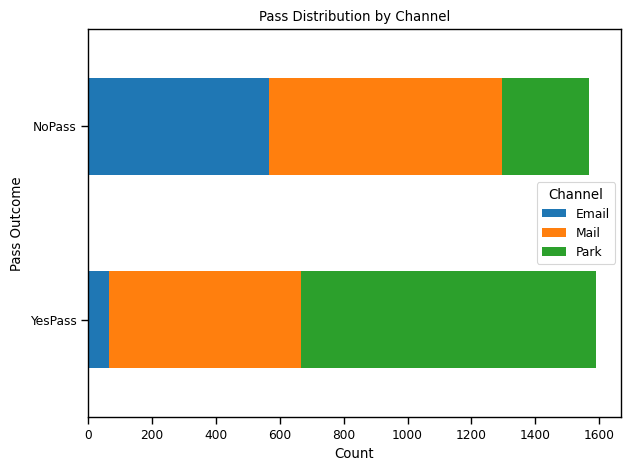

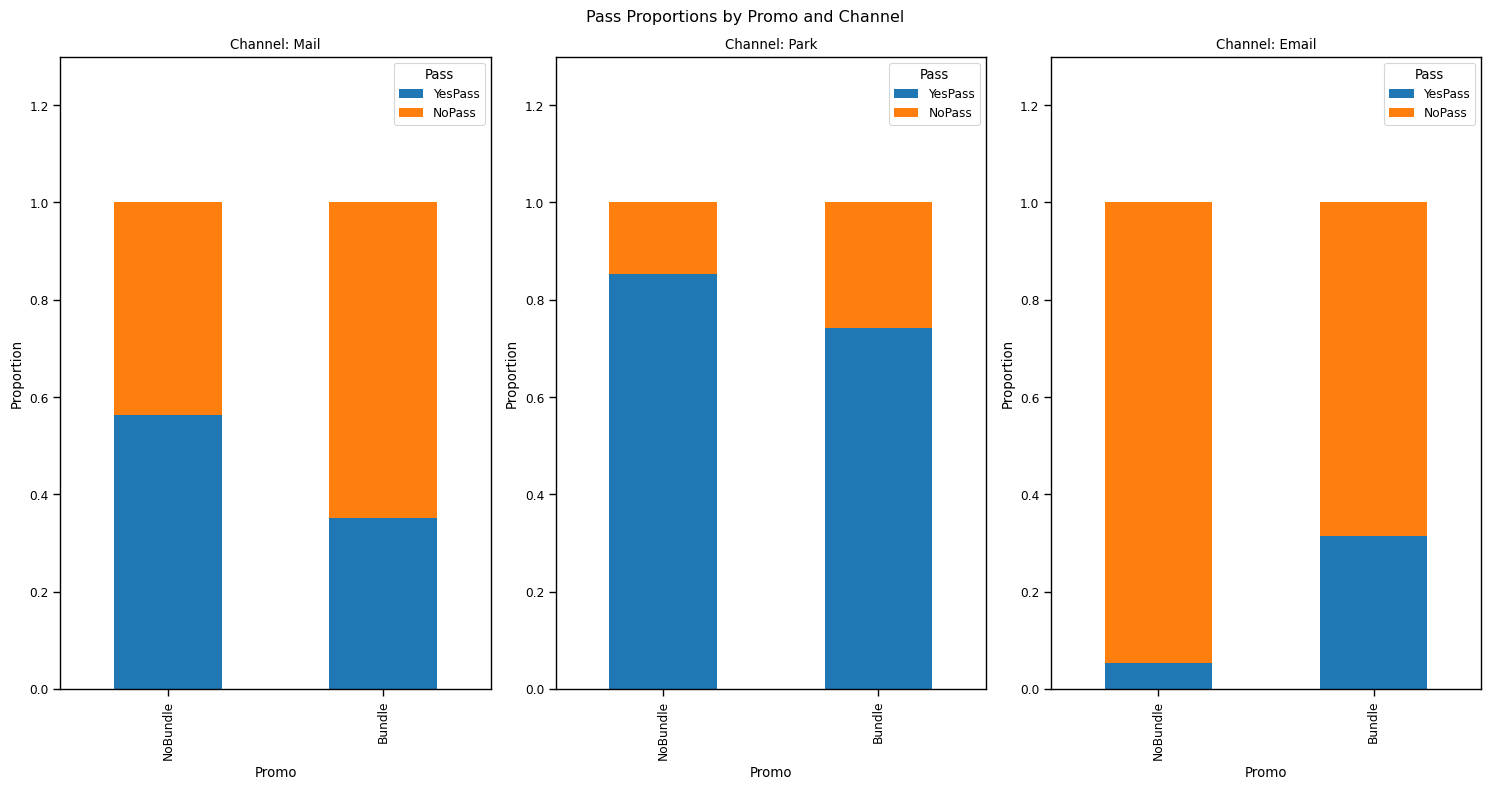

Odds Ratios:
 Intercept           0.125105
Promo[T.Bundle]     0.571085
Channel[T.Mail]     8.812507
Channel[T.Park]    41.337121
dtype: float64

Confidence Intervals:
                          0          1
Intercept         0.096648   0.161943
Promo[T.Bundle]   0.478438   0.681672
Channel[T.Mail]   6.612766  11.743993
Channel[T.Park]  30.230619  56.524069


('\nInteraction Model Confidence Intervals:\n',
                                          0           1
 Intercept                         0.037784    0.082023
 Promo[T.Bundle]                   4.766238   14.190288
 Channel[T.Mail]                  15.272038   35.233701
 Channel[T.Park]                  63.650609  170.293436
 Promo[T.Bundle]:Channel[T.Mail]   0.028170    0.091430
 Promo[T.Bundle]:Channel[T.Park]   0.031621    0.114288)

In [ ]:
# ------------------------------
# Cross-Tab: Channel Breakdown by Pass
# ------------------------------

# Unstacked count of Pass outcomes by Channel
pass_by_channel = pass_df.groupby(['Pass'], observed=True).Channel.value_counts().unstack()
print(pass_by_channel)

# ------------------------------
# Horizontal Stacked Bar Chart
# ------------------------------

# Visualize pass breakdown by channel
pass_by_channel.plot(kind='barh', stacked=True)
plt.title('Pass Distribution by Channel')
plt.xlabel('Count')
plt.ylabel('Pass Outcome')
plt.tight_layout()
plt.show()

# ------------------------------
# Proportions of Pass by Promo, Faceted by Channel
# ------------------------------

# Setup channels for subplotting
channels = ['Mail', 'Park', 'Email']
plt.figure(figsize=(15, 8))

for i, c in enumerate(channels):
    ax = plt.subplot(1, 3, i + 1)
    subset = pass_df[pass_df.Channel == c]
    
    # Normalized stacked bars of Pass proportions by Promo
    promo_pass_dist = subset.groupby('Promo', observed=True).Pass.value_counts(normalize=True).unstack()
    promo_pass_dist.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_title(f"Channel: {c}")
    ax.set_ylim(0, 1.3)
    ax.set_ylabel("Proportion")

plt.suptitle("Pass Proportions by Promo and Channel")
plt.tight_layout()
plt.show()

# ------------------------------
# Fit Logistic Model: Pass ~ Promo + Channel
# ------------------------------

pass_m2 = smf.glm(
    'Pass ~ Promo + Channel',
    data=pass_df,
    family=sm.families.Binomial()
).fit()

pass_m2.summary()

# ------------------------------
# Odds Ratios and Confidence Intervals (No Interaction Model)
# ------------------------------

# Print exponentiated coefficients
print("Odds Ratios:\n", np.exp(pass_m2.params))

# 95% CI for odds ratios
print("\nConfidence Intervals:\n", np.exp(pass_m2.conf_int()))

# ------------------------------
# Fit Logistic Model: Pass ~ Promo * Channel (with Interaction)
# ------------------------------

pass_m3 = smf.glm(
    'Pass ~ Promo * Channel',
    data=pass_df,
    family=sm.families.Binomial()
).fit()

pass_m3.summary()

# ------------------------------
# Confidence Intervals for Interaction Model
# ------------------------------

# 95% CI for interaction model
print("\nInteraction Model Confidence Intervals:\n", np.exp(pass_m3.conf_int()))

In [ ]:
# ------------------------------
# Intro to Hierarchical Models: Simulated Conjoint Data
# ------------------------------

import numpy as np
import pandas as pd

# ------------------------------
# Simulate Attribute Levels for 16 Product Profiles
# ------------------------------

np.random.seed(12814)

response_id = range(200)       # 200 individual respondents
n_questions = 16               # 16 rated profiles per respondent

# Rollercoaster attribute options
speed_options  = ['40', '50', '60', '70']       # Speed in MPH
height_options = ['200', '300', '400']          # Height in feet
const_options  = ['Steel', 'Wood']              # Construction type
theme_options  = ['Dragon', 'Eagle']            # Theming style

# Randomly assign attribute levels to the 16 profiles
speed  = np.random.choice(speed_options,  size=n_questions, replace=True)
height = np.random.choice(height_options, size=n_questions, replace=True)
const  = np.random.choice(const_options,  size=n_questions, replace=True)
theme  = np.random.choice(theme_options,  size=n_questions, replace=True)

# ------------------------------
# Construct Profile Feature DataFrame
# ------------------------------

# Combine all attributes into one DataFrame (16 rows x 4 features)
profiles_df = pd.DataFrame(
    [speed, height, const, theme],
    index=['speed', 'height', 'const', 'theme']
).T

# ------------------------------
# One-Hot Encode the Attributes for Modeling
# ------------------------------

# Convert categorical variables into 0/1 dummies
profile_dummies = pd.get_dummies(profiles_df)

# Drop base levels to avoid multicollinearity (baseline: speed_40, height_200, etc.)
profile_dummies.drop(
    ['speed_40', 'height_200', 'const_Steel', 'theme_Dragon'],
    axis=1,
    inplace=True
)

# Add intercept term manually
profiles_model = pd.concat(
    [pd.Series(np.ones(n_questions, dtype=int), name='Intercept'), profile_dummies],
    axis=1
)

# ------------------------------
# Simulate Respondent-Level Preference Weights
# ------------------------------

# Each respondent gets their own preference weights (personal utilities)
# Drawn from a multivariate normal distribution
weights = np.random.multivariate_normal(
    mean=[-3, 0.5, 1, 3, 2, 1, -0.2, -0.5],             # true average utilities
    cov=np.diag([0.2, 0.1, 0.1, 0.1, 0.2, 0.3, 1, 1]),   # variance for each coef
    size=len(response_id)                               # 200 respondents
)

# ------------------------------
# Generate Ratings for Each Respondent
# ------------------------------

# Create empty DataFrame to hold full data
conjoint_df = pd.DataFrame()

for i in response_id:
    # Simulate latent utility by dot-product of profile and respondent's weights + noise
    utility = (profiles_model * weights[i]).sum(axis=1) + np.random.normal(size=n_questions)
    
    # Convert utility into rating scale (1–10)
    ratings = pd.cut(utility, bins=10, labels=range(1, 11))

    # Copy original profile attributes and attach ratings
    conjoint_resp = profiles_df.copy()
    conjoint_resp['rating'] = pd.to_numeric(ratings)  # ensure it's numeric
    conjoint_resp['resp_id'] = i                      # track respondent
    
    # Append to master dataset
    conjoint_df = pd.concat([conjoint_df, conjoint_resp], ignore_index=True)

# ------------------------------
# Final Output: Simulated Conjoint Ratings
# ------------------------------

conjoint_df.head()


,speed,height,const,theme,rating,resp_id
0,40,400,Steel,Eagle,5,0
1,50,400,Steel,Dragon,5,0
2,40,300,Steel,Eagle,7,0
3,50,400,Steel,Eagle,7,0
4,50,300,Wood,Dragon,6,0


In [87]:
#An Initial Linear Model

#Describe the dataframe 
conjoint_df.describe(include = 'all').T

#find averages of heights
conjoint_df.groupby('height').rating.mean()

#Could do that the whole way, or do a linear model 
ride_lm = smf.ols('rating ~ speed + height + const + theme',
                  data = conjoint_df).fit()
ride_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     353.0
Date:                Sat, 23 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:23:32   Log-Likelihood:                -6793.6
No. Observations:                3200   AIC:                         1.360e+04
Df Residuals:                    3192   BIC:                         1.365e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.2633      0.110     20.591      0.000       2.048       2.479
speed[T.50]        0.7981      0.106      7.533      0.000       0.590       1.006
speed[T.60]        1.5200      0.114     13.296      0.000       1.296       1.744
speed[T.70]        4.3655      0.161     27.039      0.000       4.049       4.682
height[T.300]      2.9738      0.129     23.017      0.000       2.720       3.227
height[T.400]      1.5624      0.137     11.367      0.000       1.293       1.832
const[T.Wood]     -0.4937      0.091     -5.415      0.000      -0.672      -0.315
theme[T.Eagle]    -0.5279      0.126     -4.203      0.000      -0.774      -0.282
==============================================================================
Omnibus:                       26.616   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.735
Skew:                           0.193   Prob(JB):                     2.58e-06
Kurtosis:                       2.791   Cond. No.                         9.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""